In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold


In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

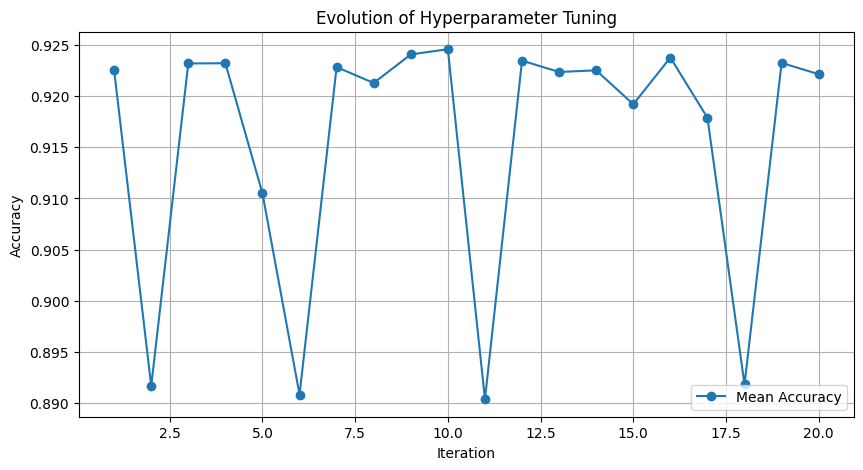

---------------------------------------------


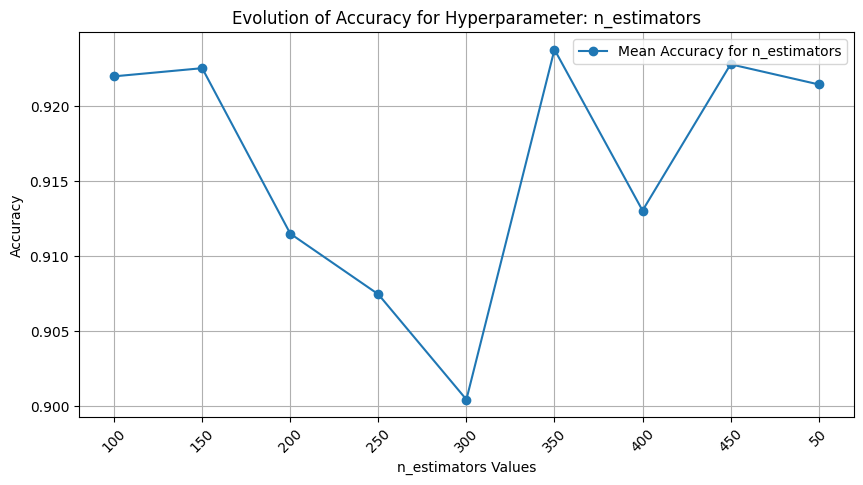

---------------------------------------------


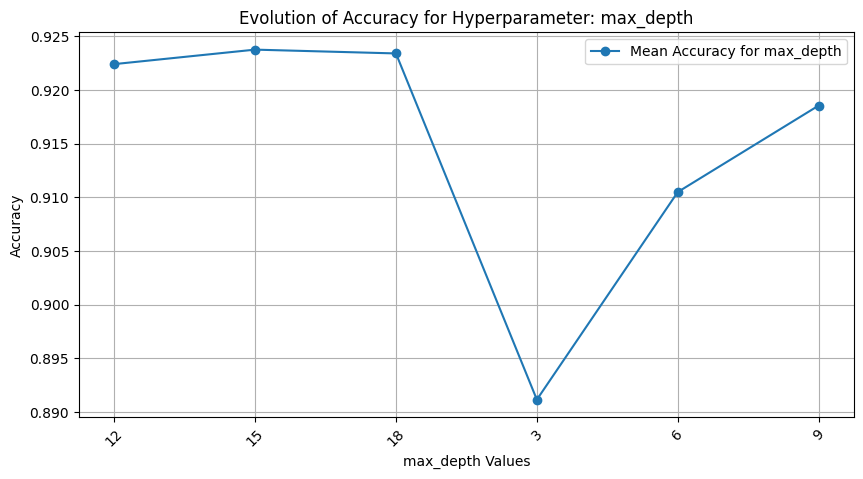

---------------------------------------------


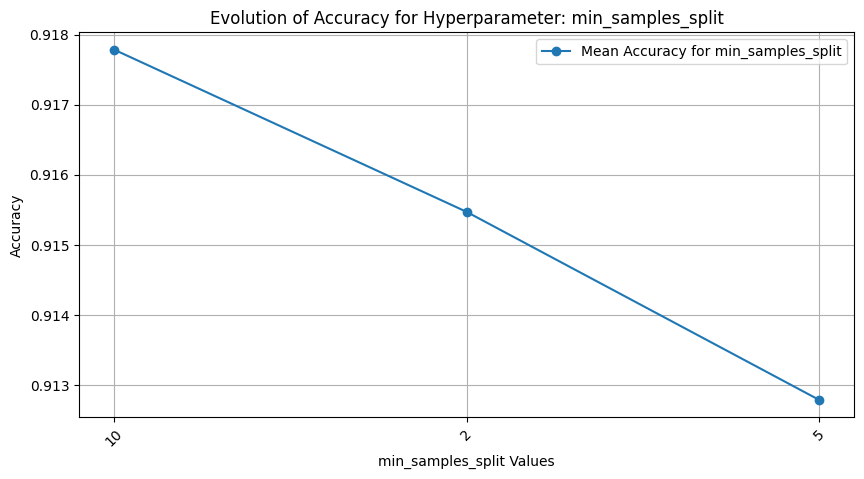

---------------------------------------------


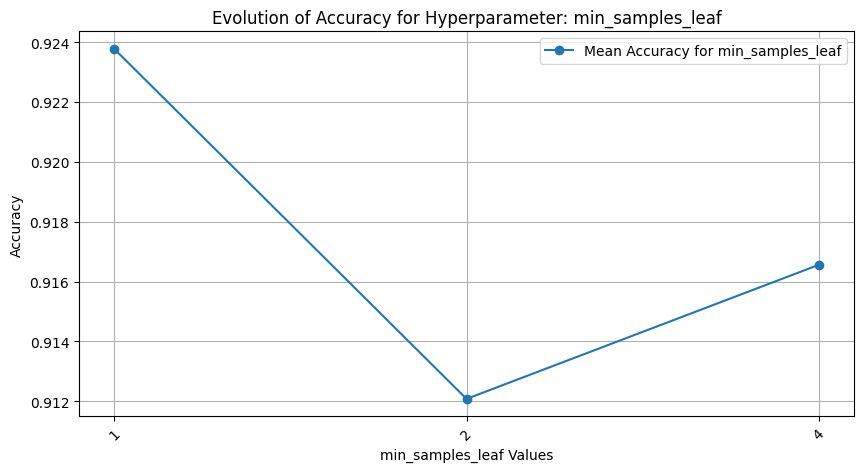

---------------------------------------------


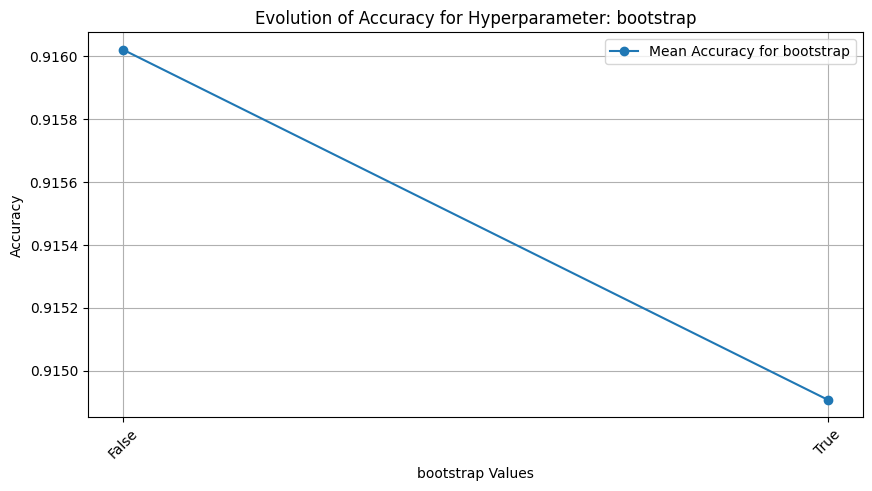

---------------------------------------------
Melhores hiperparâmetros encontrados: {'n_estimators': np.int64(400), 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': np.int64(15), 'bootstrap': False}
Acurácia: 0.8971
Precisão: 0.9158
Recall: 0.9401
F1-Score: 0.9277
AUC-ROC: 0.9528


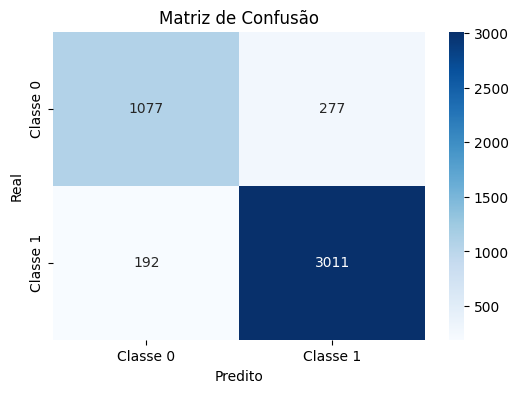


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82      1354
           1       0.92      0.94      0.93      3203

    accuracy                           0.90      4557
   macro avg       0.88      0.87      0.87      4557
weighted avg       0.90      0.90      0.90      4557



In [ ]:
# Separar features (X) e rótulos (y)
X_train = train_df.drop(columns=["binaryClass"])
y_train = train_df["binaryClass"]

X_test = test_df.drop(columns=["binaryClass"])
y_test = test_df["binaryClass"]

# Configurar validação cruzada estratificada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Converter classes de string para números (caso necessário)
if y_train.dtype == 'O':  # Verifica se os rótulos são texto (strings)
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)  # Transforma os rótulos do conjunto de teste também

# Definir o espaço de busca para os hiperparâmetros
param_grid = {
    'n_estimators': np.arange(50, 500, 50),  # Número de árvores na floresta
    'max_depth': np.arange(3, 20, 3),  # Profundidade máxima da árvore
    'min_samples_split': [2, 5, 10],  # Número mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 4],  # Número mínimo de amostras em cada folha
    'bootstrap': [True, False]  # Uso do Bootstrap no treinamento
}

# Otimizar hiperparâmetros usando RandomizedSearchCV
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(rf, param_grid, n_iter=20, cv=5, scoring='f1', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Salvar resultados
results = pd.DataFrame(random_search.cv_results_)
results[['mean_test_score', 'std_test_score', 'params']].to_csv("hyperparameter_tuning_results.csv", index=False)

# Plotar evolução dos resultados
def plot_search_results(results):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 21), results['mean_test_score'], marker='o', linestyle='-', label='Mean Accuracy')
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.title("Evolution of Hyperparameter Tuning")
    plt.legend()
    plt.grid()
    plt.show()
    print('---------------------------------------------')

plot_search_results(results)

def plot_hyperparameter_evolution(results, param_name):
    # Filtrar as colunas relevantes para o hiperparâmetro
    param_values = [str(param) for param in results['param_' + param_name]]
    mean_scores = results['mean_test_score']
    std_scores = results['std_test_score']

    # Criar um DataFrame com as informações
    df = pd.DataFrame({
        'param_value': param_values,
        'mean_score': mean_scores,
        'std_score': std_scores
    })

    # Agrupar por valor do hiperparâmetro e calcular a média da acurácia
    df_grouped = df.groupby('param_value').agg({'mean_score': 'mean', 'std_score': 'mean'}).reset_index()

    # Plotar a evolução da média da acurácia
    plt.figure(figsize=(10, 5))
    plt.plot(df_grouped['param_value'], df_grouped['mean_score'], marker='o', linestyle='-', label=f'Mean Accuracy for {param_name}')
    plt.xlabel(f"{param_name} Values")
    plt.ylabel("Accuracy")
    plt.title(f"Evolution of Accuracy for Hyperparameter: {param_name}")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()
    print('---------------------------------------------')

for param_name in param_grid.keys():
    plot_hyperparameter_evolution(results, param_name)

# Melhor modelo encontrado
best_rf = random_search.best_estimator_
print(f"Melhores hiperparâmetros encontrados: {random_search.best_params_}")

# Reajustar o modelo final com os melhores parâmetros
best_rf.fit(X_train, y_train)

# Avaliação no conjunto de teste
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]  # Probabilidade para a classe positiva

# Cálculo das métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_prob)

# Exibir os resultados
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# 🔥 Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# 📊 Visualizar Matriz de Confusão
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))


<ipython-input-15-c060121b4e5a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=metrics_rf, palette='viridis')


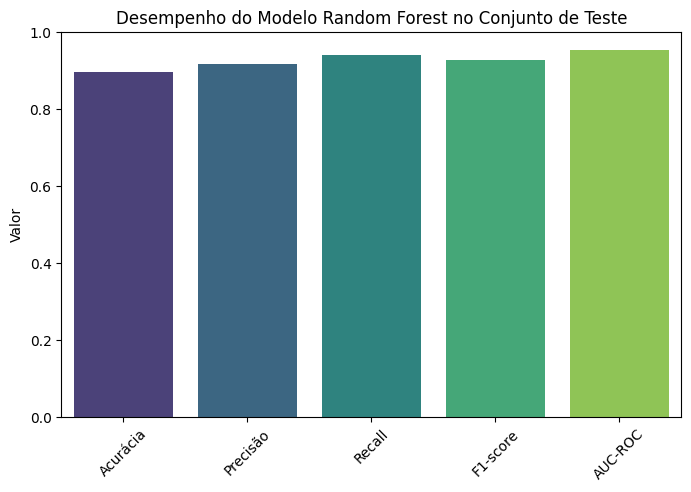

F1-score no Treino (Random Forest): 0.9898
F1-score no Teste (Random Forest): 0.9277
O modelo apresenta um equilíbrio entre treino e teste.


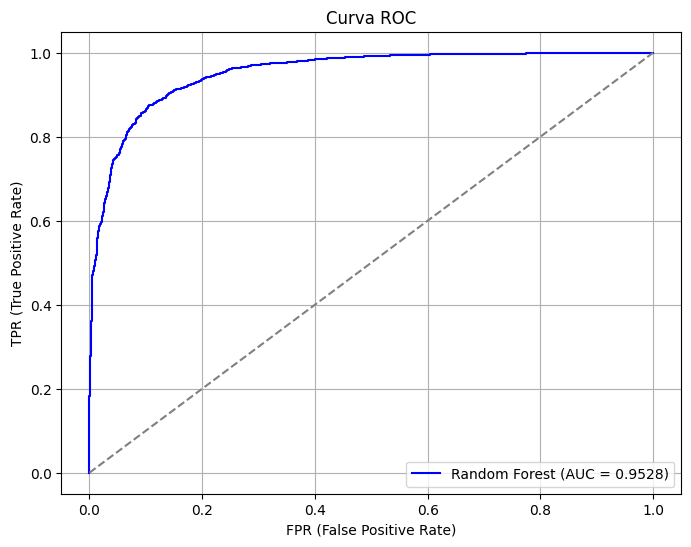


Conclusões:
O modelo Random Forest foi avaliado usando diversas métricas. O melhor desempenho foi atingido com os seguintes hiperparâmetros:
{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 15, 'bootstrap': False}
Os resultados sugerem que o modelo é capaz de generalizar bem, sem sinais evidentes de overfitting ou underfitting.


In [ ]:
# 1. Comparação de Desempenho
metrics_rf = [accuracy, precision, recall, f1, auc_roc]
labels = ["Acurácia", "Precisão", "Recall", "F1-score", "AUC-ROC"]
plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=metrics_rf, palette='viridis')
plt.title("Desempenho do Modelo Random Forest no Conjunto de Teste")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.show()

# 2. Overfitting vs. Underfitting
train_pred_rf = best_rf.predict(X_train)
train_f1_rf = f1_score(y_train, train_pred_rf)
print(f"F1-score no Treino (Random Forest): {train_f1_rf:.4f}")
print(f"F1-score no Teste (Random Forest): {f1:.4f}")

if train_f1_rf - f1 > 0.1:
    print("O modelo pode estar sofrendo de overfitting.")
elif f1 - train_f1_rf > 0.1:
    print("O modelo pode estar sofrendo de underfitting.")
else:
    print("O modelo apresenta um equilíbrio entre treino e teste.")

# 3. Curva ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob)  # Usando y_prob para calcular a curva ROC (probabilidade da classe positiva)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_roc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.title("Curva ROC")
plt.legend()
plt.grid()
plt.show()

# 4. Conclusões
print("\nConclusões:")
print("O modelo Random Forest foi avaliado usando diversas métricas. O melhor desempenho foi atingido com os seguintes hiperparâmetros:")
print(random_search.best_params_)  # Exibe os melhores hiperparâmetros encontrados no RandomizedSearchCV
print("Os resultados sugerem que o modelo é capaz de generalizar bem, sem sinais evidentes de overfitting ou underfitting.")
